# Calculating the losses due to butt-to-butt fiber coupling with an air filled gap
-------------
Based on [my calculations](LPmodes.ipynb), the intensity of the counterpropagating field doesn't have to be as much as the forward propagating one for a standing wave to be established.

Used extensively for the formulas was this __[article]( https://cdn.intechopen.com/pdfs/27371/InTech-Optical_performance_analysis_of_single_mode_fiber_connections.pdf)__
They cite 4 sources of light loss when butt coupling **perfectly cleaved** fibers. These are:
<div>
<img src="fiberlosses.png" width="500"/>
</div


The only one I anticipate as being negligible is the mode field mismatch, since I am using the same fiber. The tilt misalignment will also most lilely be quite small due to the machining of the groove of the fiber holder. I'll first calculate loss as a function of air gap and lateral displacement.<br>

As a function of air gap, we have transmission coefficient $T$ given by
\begin{equation}
T = \frac{1}{Z^2+1}
\end{equation}
where 
\begin{equation}
Z = \frac{\lambda S}{2 \pi n \omega^2}
\end{equation}
where $S$ is the gap size, $n$ is the refractive index of air and $\omega$ is the MFD of the two fibers

In [3]:
import numpy as np

def Z(lam,S,n,omega):
    return (lam*S)/(2*np.pi*n*(omega**2))

def T_ag(Z):
    return 1/(Z**2 + 1)

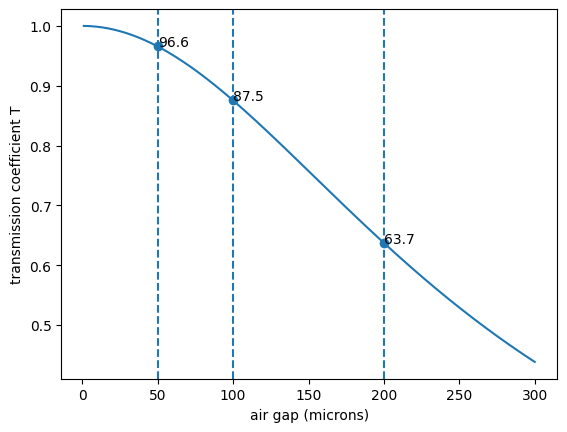

In [27]:
import matplotlib.pyplot as plt

# lab values
wavelength = 1064e-9 #m
airgap = np.linspace(1e-6,300e-6,300) #m
RI = 1
MFD = 6.7e-6 #m

Z_airgap = Z(wavelength,airgap,RI,MFD)
T_airgap = T_ag(Z_airgap)

fig,ax = plt.subplots()
ax.plot(airgap*10**6,T_airgap)
ax.set_xlabel('air gap (microns)')
ax.set_ylabel('transmission coefficient T')
poi = np.array([50e-6,100e-6,200e-6]) # add points of interest and labels
for i in range(len(poi)):
    plt.axvline(poi[i]*10**6, linestyle='--')
Z_poi = Z(wavelength,poi,RI,MFD)
T_poi = T_ag(Z_poi)
T_labels = np.around(T_poi,3)*100
ax.scatter(poi*10**6,T_poi)
for i, txt in enumerate(T_labels):
    ax.annotate(txt, (poi[i]*10**6, T_poi[i]))
plt.show()



as a function of lateral offset $d$, we have
\begin{equation}
T = exp \left( -\frac{d^2}{\omega^2} \right)
\end{equation}

In [6]:
def T_lo(d,omega):
    return np.exp(-(d**2)/(omega**2))

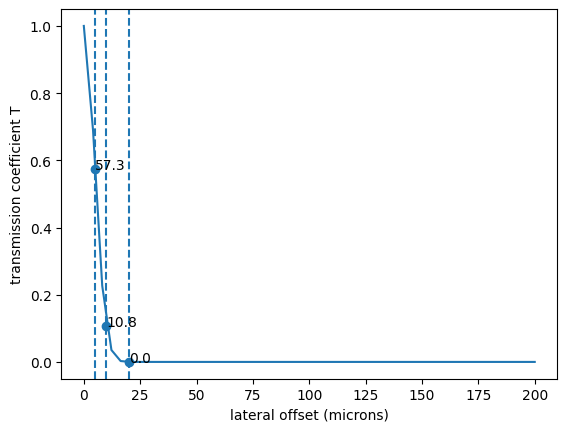

In [30]:
offset = np.linspace(0,200e-6) #m
T_offset = T_lo(offset,MFD)

fig,ax = plt.subplots()
ax.plot(offset*10**6,T_offset)
ax.set_xlabel('lateral offset (microns)')
ax.set_ylabel('transmission coefficient T')
poi = np.array([5e-6,10e-6,20e-6])
for i in range(len(poi)):
    plt.axvline(poi[i]*10**6, linestyle='--')
T_poi = T_lo(poi,MFD)
T_labels = np.around(T_poi,3)*100
ax.scatter(poi*10**6,T_poi)
for i, txt in enumerate(T_labels):
    ax.annotate(txt, (poi[i]*10**6, T_poi[i]))
plt.show()